In [16]:
def analyze(states, actions):
    speed_norms = states[:, :, 2:].norm(dim=2)
    diffs = speed_norms[:, 1:] - speed_norms[:, :-1]
    timesteps = diffs / (actions[:, :, 0] + 1e-4)
    return timesteps

def analyze_batch(batch):
    return analyze(batch['target_states'], batch['actions'][:, 1:])

In [23]:
import torch
from ppuu.data.dataloader import Dataset, DataStore
from torch.utils.data import DataLoader

ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/traffic-data_offroad/state-action-cost/data_i80_v0/"
# ds_path = "/misc/vlgscratch4/LecunGroup/nvidia-collab/vlad/traffic-data_offroad_50_test_train_same/state-action-cost/data_i80_v0/"
data_store = DataStore(ds_path)

dataset = Dataset(
    data_store, "val", 20, 30, size=1000, normalize=False, shift=False, random_actions=False,
)

loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
)

batch = next(iter(loader))

loader = [torch.load('/home/us441/work/forked/ppuu/bad_batch.t')]
timesteps = []
for batch in loader:
    timesteps.append(analyze_batch(batch))

timesteps = torch.stack(timesteps).flatten()
timesteps.clamp_(min=-0.5, max=0.5)
timesteps

tensor([0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
        0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
        0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
        0.0999, 0.0999], device='cuda:0')

In [11]:
print(batch['s'])

tensor([1402])


In [12]:
print(batch['t'])

tensor([165])


In [13]:
print(analyze(batch['target_states'], batch['actions'][:, 1:]))

tensor([[0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999]])


In [14]:
from matplotlib import pyplot as plt

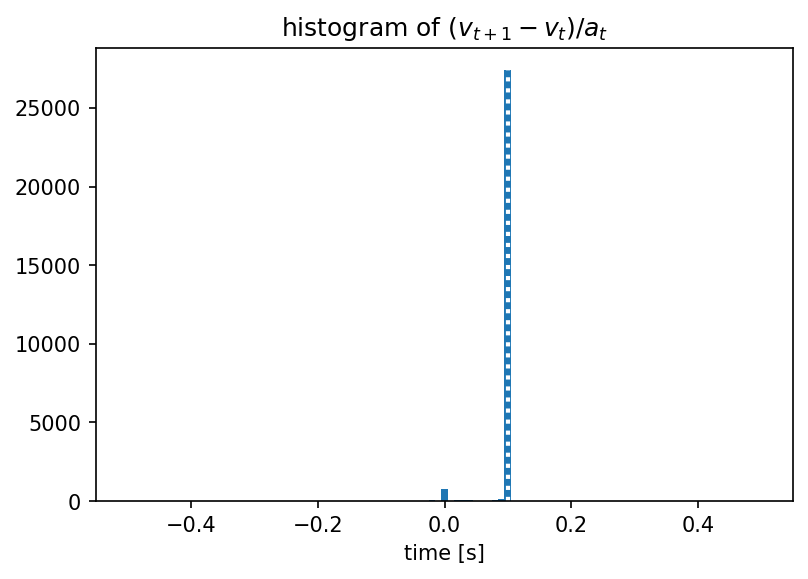

In [15]:
def plot(timesteps):
    plt.figure(dpi=150)
    plt.hist(timesteps, bins=101, align='mid', range=(-0.5, 0.5))
    plt.xlabel('time [s]')
    plt.axvline(0.1, c='w', ls=':', lw=2)
    plt.title('histogram of $(v_{t+1} - v_{t}) / a_t$')
plot(timesteps)

# Trying one concrete episode

In [55]:
s = 26
acc = []
# for s in range(100):
states = data_store.states[s][:, 0, :]
actions = data_store.actions[s]
res = analyze(states.unsqueeze(0), actions[1:].unsqueeze(0))
print(res)
acc.append(res)

acc = torch.cat(acc, axis=-1).flatten()

i_states = states[1:21].unsqueeze(0)
t_states = states[21:51].unsqueeze(0)
_actions = actions[21:51].unsqueeze(0)
print((batch['input_states'] - i_states).pow(2).sum())
print((batch['target_states'] - t_states).pow(2).sum())
print((batch['actions'] - _actions).pow(2).sum())
print(analyze(t_states, _actions[:, 1:]))
# plot(acc)
print(t_states.shape)

tensor([[0.0999, 0.1000, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0997, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.1000, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0998, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999, 0.0999,
         0.0999, 0.0999, 0.0

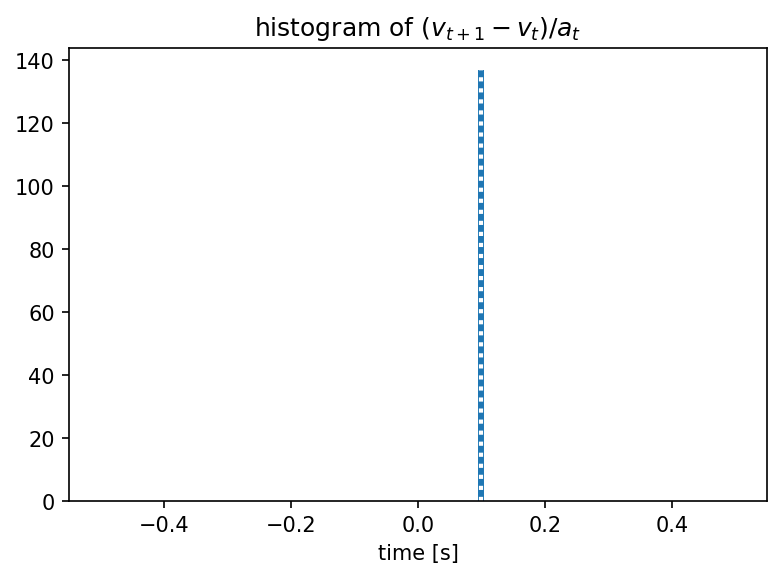

In [56]:
plot(acc)

# Opening values from traffic gym
I ran traffic gym while printing the supposed delta t, I suspect the problem is in this 1e-3 there. Let's see what the values are.

In [46]:
with open('/home/us441/work/pytorch-PPUU_offroad/ts', 'r') as f:
    x = list(map(float, f.read().split(' ')))

In [47]:
x = sorted(x)
print(min(x))
print(max(x))
print(sum(x) / len(x))

-inf
inf
nan


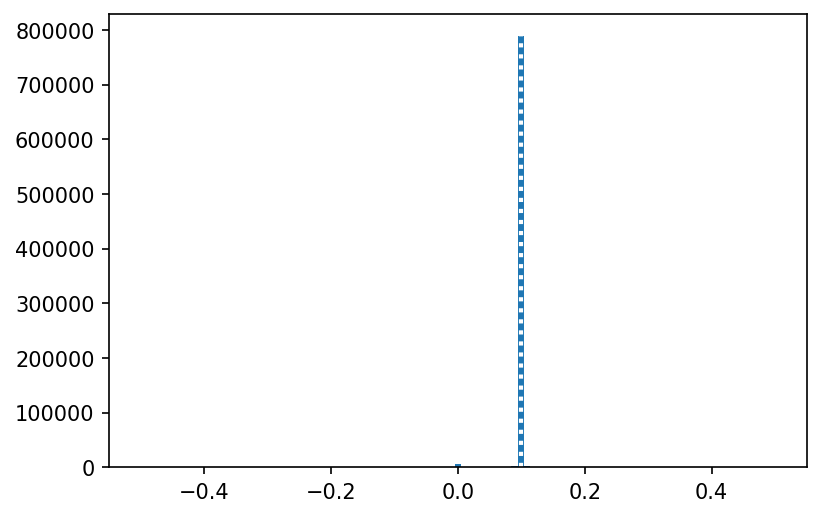

In [48]:
plt.figure(dpi=150)
plt.hist(x, bins=101, align='mid', range=(-0.5, 0.5))
plt.axvline(0.1, c='w', ls=':', lw=2)

In [49]:
x[100]

-0.0

In [50]:
x[-500]

0.0999014601111412